### 2.1.4 线性SVM决策过程的可视化
我们可以使用sklearn来为可视化决策边界，支持向量，以及决策边界平行的两个超平面。

1. 导入需要的模块

In [1]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

2. 可视化数据，观察大致分布

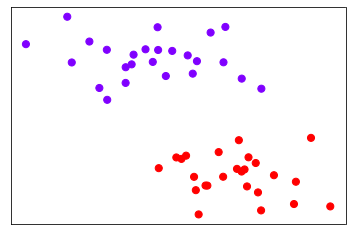

In [2]:
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")  # c=y的意思是将y数组的取值作为散点图中每个数据点的颜色
plt.xticks([])
plt.yticks([])
plt.show()

3. 画决策边界：理解函数contour
*matplotlib.axes.Axes.contour([X, Y,] Z, [levels], \*\*kwargs)*

Contour是我们专门用来绘制等高线的函数。等高线，本质上是在二维图像上表现三维图像的一种形式，其中两维X和Y是两条坐标轴上的取值，而Z表示高度。Contour就是将由X和Y构成平面上的所有点中，高度一致的点连接成线段的函数，在同一条等高线上的点一定具有相同的Z值。我们可以利用这个性质来绘制我们的决策边界。

首先，我们需要获取样本构成的平面，作为一个对象。


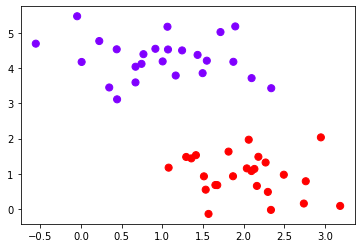

In [3]:
# 首先要有散点图
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
ax = plt.gca()  # 获取当前子图，如果不存在则创建新的子图

有了这个平面，我们需要在平面上制作一个足够细的网格，来代表我们“平面上的所有点”。

4. 画决策边界：制作网格，理解函数meshgrid


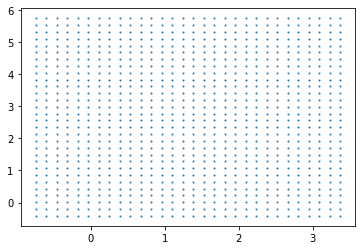

In [4]:
#获取平面上两条坐标轴的最大值和最小值
xlim = ax.get_xlim()  # 元组(min,max)
ylim = ax.get_ylim()

#在最大值和最小值之间形成30个规律的数据
axisx = np.linspace(xlim[0], xlim[1], 30)
axisy = np.linspace(ylim[0], ylim[1], 30)

axisx, axisy = np.meshgrid(axisx, axisy)
#我们将使用这里形成的二维数组作为我们contour函数中的X和Y
#使用meshgrid函数将两个一维向量转换为特征矩阵
#核心是将两个特征向量广播，以便获取y.shape * x.shape这么多个坐标点的横坐标和纵坐标

xy = np.vstack([axisx.ravel(), axisy.ravel()]).T
#其中ravel()是降维函数，vstack能够将多个结构一致的一维数组按行堆叠起来
#xy就是已经形成的网格，它是遍布在整个画布上的密集的点

plt.scatter(xy[:, 0], xy[:, 1], s=1, cmap="rainbow")

有了网格后，我们需要计算网格所代表的“平面上所有的点”到我们的决策边界的距离。所以我们需要我们的模型和决策边界。

5. 建模，计算决策边界并找出网格上每个点到决策边界的距离

(-0.41872382476349596, 5.754870487889891)

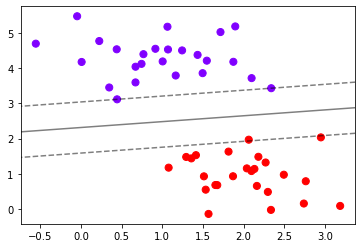

In [5]:
#建模，通过fit计算出对应的决策边界
clf = SVC(kernel="linear").fit(X, y)  #计算出对应的决策边界
Z = clf.decision_function(xy).reshape(axisx.shape)
#重要接口decision_function，返回每个输入的样本所对应的到决策边界的距离
#然后再将这个距离转换为axisx的结构，这是由于画图的函数contour要求Z的结构必须与X和Y保持一致

#首先要有散点图
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
ax = plt.gca()  #获取当前的子图，如果不存在，则创建新的子图
#画决策边界和平行于决策边界的超平面
ax.contour(axisx, axisy, Z
           , colors="k"
           , levels=[-1, 0, 1]  #画三条等高线，分别是Z为-1，Z为0和Z为1的三条线
           , alpha=0.5  #透明度
           , linestyles=["--", "-", "--"])

ax.set_xlim(xlim)  #设置x轴取值
ax.set_ylim(ylim)

6. 将完整绘图过程包装成一个函数

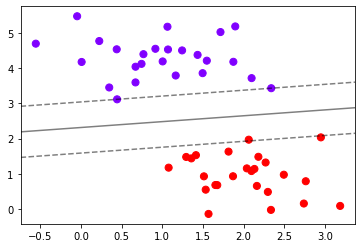

In [6]:
def plot_svc_decision_function(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


#则整个绘图过程可以写成：
clf = SVC(kernel="linear").fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
plot_svc_decision_function(clf)

7. 探索建好的模型

In [7]:
clf.predict(X)
#根据决策边界，对X中的样本进行分类，返回的结构为n_samples

clf.score(X, y)
#返回给定测试数据和标签的平均准确度

clf.support_vectors_
#返回支持向量

clf.n_support_
#返回每个类中支持向量的个数

array([2, 1])

8. 推广到非线性情况

我们之前所讲解的原理，以及绘图的过程，都是基于数据本身是线性可分的情况。如果把数据推广到非线性数据，比如说环形数据上呢？

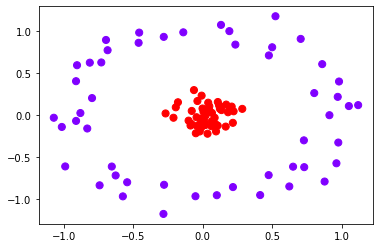

In [8]:
# factor=0.1表示内外圆之间的距离因子，即内圆的半径是外圆半径的0.1倍；
# noise=0.1表示噪声的标准差，即样本点的位置会在水平和竖直方向上加上一定程度的随机扰动，增加了数据的随机性。
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=0.1, noise=.1)

# X.shape (100,2)
# y.shape  (100,)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
plt.show()

试试看用我们已经定义的函数来划分这个数据的决策边界：

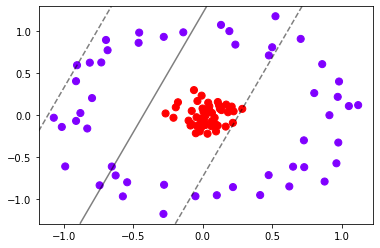

In [9]:
clf = SVC(kernel="linear").fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
plot_svc_decision_function(clf)

明显，现在线性SVM已经不适合于我们的状况了，我们无法找出一条直线来划分我们的数据集，让直线的两边分别是两种类别。这个时候，如果我们能够在原本的X和y的基础上，添加一个维度r，变成三维，我们可视化这个数据，来看看添加维度让我们的数据如何变化。

9. 为非线性数据增加维度并绘制3D图像

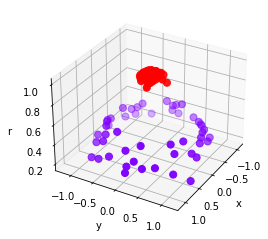

In [10]:
#定义一个由x计算出来的新维度r
r = np.exp(-(X ** 2).sum(1))  # (100,)

rlim = np.linspace(min(r), max(r), 100)


#定义一个绘制三维图像的函数
#elev表示上下旋转的角度
#azim表示平行旋转的角度
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection="3d")
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='rainbow')
    ax.view_init(elev=elev, azim=azim)  #设置视角
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("r")
    plt.show()


plot_3D()

可以看见，此时此刻我们的数据明显是线性可分的了：我们可以使用一个平面来将数据完全分开，并使平面的上方的所有数据点为一类，平面下方的所有数据点为另一类。
此时我们的数据在三维空间中，我们的超平面就是一个二维平面,就是我们的决策边界。我们刚才做的，计算r，并将r作为数据的第三维度来将数据升维的过程，被称为“核变换”，就是**将数据投影到高维空间中，以寻找能够将数据完美分割的超平面，就是说寻找能够让数据线性可分的高维空间**。为了详细解释这个过程，我们需要引入SVM中的核心概念：**核函数**。

### 2.2.2 重要参数kernel

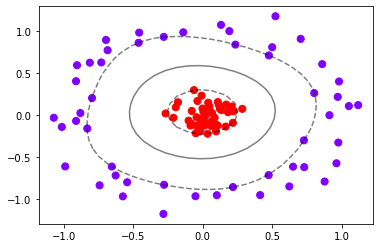

In [12]:
clf = SVC(kernel="rbf").fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")
plot_svc_decision_function(clf)

可以看到，决策边界被完美地找了出来。

### 2.2.3 探索核函数在不同数据集上的表现
除了"linear"以外的核函数都能够处理非线性情况，那究竟什么时候选择哪一个核函数呢？遗憾的是，关于核函数在不同数据集上的研究甚少，谷歌学术上的论文中也没有几篇是研究核函数在SVM中的运用的，更多的是关于核函数在深度学习，神经网络中如何使用。在sklearn中，也没有提供任何关于如何选取核函数的信息。

但无论如何，我们还是可以通过在不同的核函数中循环去找寻最佳的核函数来对核函数进行一个选取。接下来我们就通过一个例子，来探索一下不同数据集上在不同核函数的表现。我们现在有一系列线性或非线性可分的数据，我们希望通过绘制SVC在不同核函数下的决策边界并计算SVC在不同核函数下分类准确率来观察核函数的效用。

1. 导入所需要的库和模块

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.datasets import make_circles, make_moons, make_blobs, make_classification

2. 创建数据集，定义核函数的选择

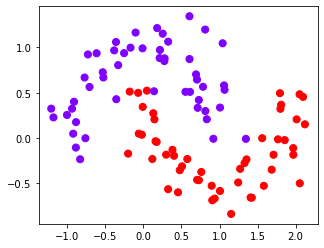

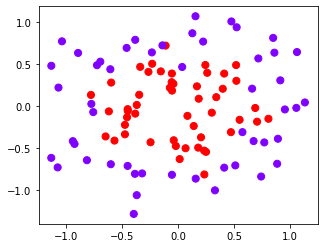

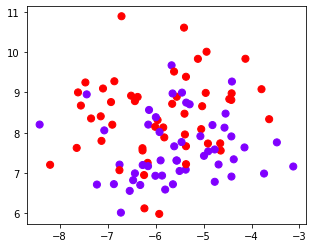

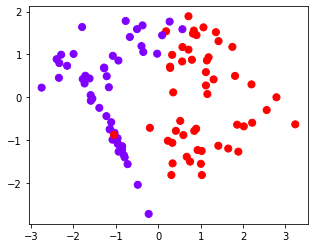

In [14]:
#样本数量
n_samples = 100

#创建4个数据集
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),  #factor表示内圆是外圆半径的多少倍
    make_blobs(n_samples=n_samples, centers=2, random_state=5),  #centers表示中心点的个数
    #n_features表示特征数，n_informative表示有用的特征数，n_redundant表示冗余的特征数
    make_classification(n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, random_state=5)
]

# 四个核函数
Kernel = ["linear", "poly", "rbf", "sigmoid"]

# 四个数据集分别是什么样子呢？
for X, Y in datasets:
    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap="rainbow")

我们总共有四个数据集，四种核函数，我们希望观察每种数据集下每个核函数的表现。**横轴为不同的核函数，纵轴为不同的数据集**，我们总共需要16个子图来展示分类结果。而同时，我们还希望观察图像本身的状况，所以我们总共需要20个子图，其中第一列是原始图像分布，后面四列分别是这种分布下不同核函数的表现。

3. 构建子图，循环绘图

相关函数及参数解释：
`zorder=10`: 控制绘制顺序，具有较高zorder值的元素将绘制在具有较低zorder值的元素之上。这里设置为10，以确保散点图在其他可能的图形元素之上。
`cmap=plt.cm.Paired`: 使用Paired颜色映射。这是一个离散的颜色映射，适用于表示具有不同类别的数据点。plt.cm是matplotlib的内置颜色映射模块。
`edgecolors='k'`: 数据点边缘的颜色。这里设置为'k'，表示黑色。这有助于更清楚地区分相邻的数据点。
`facecolors='none'`: 数据点内部的颜色。这里设置为'none'，表示无颜色填充。这有助于更清楚地区分相邻的数据点。
`np.mgrid`:合并了之前使用的np.linspace和np.meshgrid的用法.一次性使用最大值和最小值来生成网格 表示为[起始值：结束值：步长] 如果步长是复数，则其整数部分就是起始值和结束值之间创建的点的数量，并且结束值被包含在内。
`np.c_`:在列方向上连接两个向量，生成两列。

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_11360/4099992789.py:35: UserWarning: No contour levels were found within the data range.
  ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])


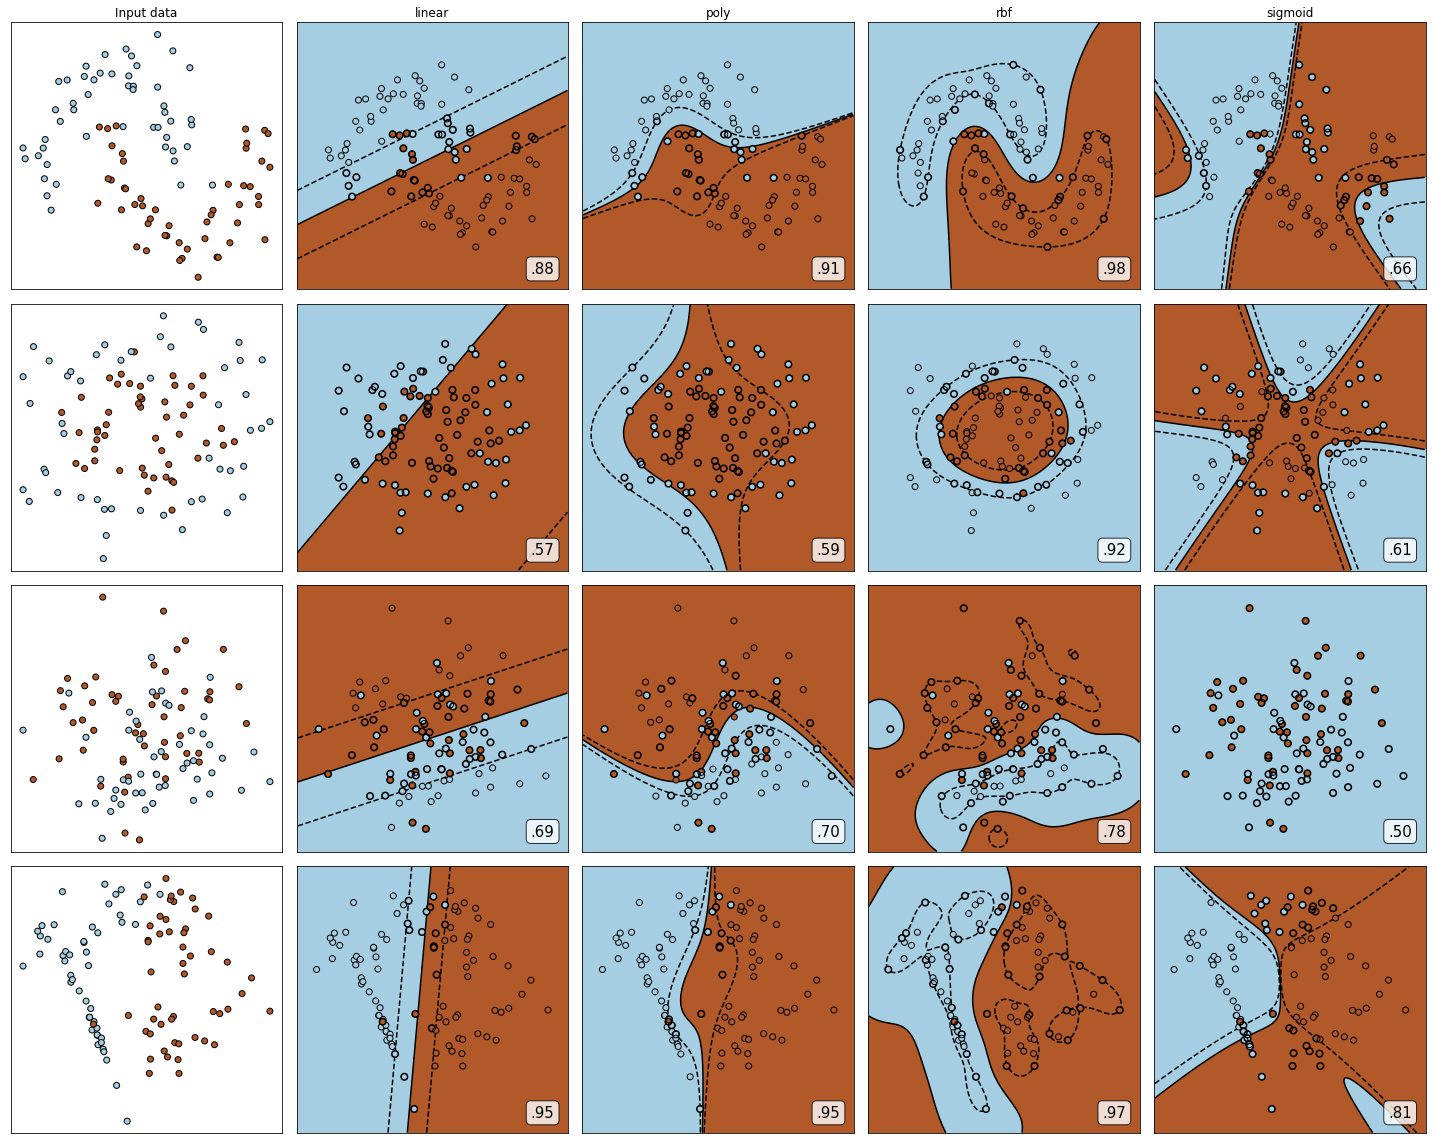

In [37]:
nrows = len(datasets)
ncols = len(Kernel) + 1
# 创建画布，共20个子图，共四行五列，第一列为原始数据分布，后面四列为不同核函数下的分类结果
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

#第一层循环：在不同的数据集中循环
for ds_index, (X, Y) in enumerate(datasets):

    #在图像中的第一列，放置原数据的分布
    ax = axes[ds_index, 0]
    if ds_index == 0:  # 设置第一列图的标题
        ax.set_title("Input data")
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolors='k')
    ax.set_xticks([])  # 坐标轴不显示刻度
    ax.set_yticks([])

    #第二层循环：在不同的核函数中循环
    #从图像的第二列开始，一个个填充分类结果
    for kn_index, ker in enumerate(Kernel):
        ax = axes[ds_index, kn_index + 1]  #定义子图位置
        clf = svm.SVC(kernel=ker, gamma=2).fit(X, Y)
        score = clf.score(X, Y)

        # 绘制图像本身分布的散点图
        ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolors='k')
        # 绘制支持向量,支持向量在sklearn中的属性：support_vectors_
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50, facecolors='none', zorder=10,
                   edgecolors='k')
        # 绘制决策边界
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]  #一个函数直接生成网格采样点
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired, shading='auto')  #填充等高线不同区域的颜色
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
        ax.set_xticks([])
        ax.set_yticks([])
        if ds_index == 0:  #设置第一行标题
            ax.set_title(ker)
        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0')  # lstrip() 方法用于截掉字符串左边的空格或指定字符
                , size=15
                , bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')  #设置文本框区域，白色底色
                , transform=ax.transAxes  #设置文本框相对于坐标轴的位置，就是ax子图的坐标轴本身
                , horizontalalignment='right')  #设置文本框中文字的位置，右对齐
plt.tight_layout()  #自动调整子图参数，使之填充整个图像区域
plt.show()

可以观察到，线性核函数和多项式核函数在非线性数据上表现会浮动，如果数据相对线性可分，则表现不错，如果是像环形数据那样彻底不可分的，则表现糟糕。在线性数据集上，线性核函数和多项式核函数即便有扰动项也可以表现不错，可见多项式核函数是虽然也可以处理非线性情况，但更偏向于线性的功能。

Sigmoid核函数就比较尴尬了，它在非线性数据上强于两个线性核函数，但效果明显不如rbf，它在线性数据上完全比不上线性的核函数们，对扰动项的抵抗也比较弱，所以它功能比较弱小，很少被用到。

**rbf，高斯径向基核函数基本在任何数据集上都表现不错，属于比较万能的核函数**。个人的经验是，无论如何先试试看高斯径向基核函数，它适用于核转换到很高的空间的情况，在各种情况下往往效果都很不错，如果rbf效果不好，那我们再试试看其他的核函数。另外，多项式核函数多被用于图像处理之中。

### 2.2.4 探索核函数的优势和缺陷

看起来，除了Sigmoid核函数，其他核函数效果都还不错。但其实rbf和poly都有自己的弊端，我们使用乳腺癌数据集作为例子来展示一下：

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from time import time
import datetime

data = load_breast_cancer()
X = data.data  #(569, 30)
y = data.target  # 0 1
# np.unique(y)
# plt.scatter(X[:, 0], X[:, 1], c=y)
# plt.show()

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)
# Kernel = ["linear", "poly", "rbf", "sigmoid"]
# 如果使用上面一行的核函数，会发现怎么跑都跑不出来。模型一直停留在线性核函数之后，就没有再打印结果了。
# 这证明，多项式核函数此时此刻要消耗大量的时间，运算非常的缓慢。让我们在循环中去掉多项式核函数，使用下面一行的核函数，再试试看能否跑出结果：
# Kernel = ["linear", "rbf", "sigmoid"]
# 我们可以有两个发现。首先，乳腺癌数据集是一个线性数据集，线性核函数跑出来的效果很好。rbf和sigmoid两个
# 擅长非线性的数据从效果上来看完全不可用。其次，线性核函数的运行速度远远不如非线性的两个核函数。
# 如果数据是线性的，那我们取消degree参数注释，调整为1，多项式核函数应该也可以得到不错的结果：
Kernel = ["linear", "poly", "rbf", "sigmoid"]

for kernel in Kernel:
    time0 = time()
    clf = SVC(kernel=kernel, gamma="auto"
              , degree=1
              , cache_size=5000  #使用计算机内存作为缓存(MB)，加快运算速度
              ).fit(Xtrain, Ytrain)
    print("The accuracy under kernel %s is %f" % (kernel, clf.score(Xtest, Ytest)))
    print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))  # 分钟：秒：微秒

The accuracy under kernel linear is 0.929825
00:00:500026
The accuracy under kernel poly is 0.923977
00:00:093756
The accuracy under kernel rbf is 0.596491
00:00:062517
The accuracy under kernel sigmoid is 0.596491
00:00:000000


简单函数示例：

In [34]:
from time import time
import datetime

# time()函数用于获取当前时间戳
now = time()
datetime.datetime.fromtimestamp(now).strftime("%Y-%m-%d %H:%M:%S")  # 格式化日期

'2023-05-01 14:40:02'

多项式核函数的运行速度立刻加快了，并且精度也提升到了接近线性核函数的水平，可喜可贺。但是，我们之前的实验中，我们了解说，rbf在线性数据上也可以表现得非常好，那在这里，为什么跑出来的结果如此糟糕呢？

其实，这里**真正的问题是数据的量纲问题**。回忆一下我们如何求解决策边界，如何判断点是否在决策边界的一边？是靠计算”距离“，虽然我们不能说SVM是完全的距离类模型，但是它严重受到数据量纲的影响。让我们来探索一下乳腺癌数据集的量纲：

In [23]:
import pandas as pd

data = pd.DataFrame(X)
data.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
0,569.0,14.127292,3.524049,6.981000,8.458360,9.529200,10.260000,11.700000,13.370000,15.780000,19.530000,24.371600,28.11000
1,569.0,19.289649,4.301036,9.710000,10.930400,13.088000,14.078000,16.170000,18.840000,21.800000,24.992000,30.652000,39.28000
2,569.0,91.969033,24.298981,43.790000,53.827600,60.496000,65.830000,75.170000,86.240000,104.100000,129.100000,165.724000,188.50000
3,569.0,654.889104,351.914129,143.500000,215.664000,275.780000,321.600000,420.300000,551.100000,782.700000,1177.400000,1786.600000,2501.00000
4,569.0,0.096360,0.014064,0.052630,0.068654,0.075042,0.079654,0.086370,0.095870,0.105300,0.114820,0.132888,0.16340
5,569.0,0.104341,0.052813,0.019380,0.033351,0.040660,0.049700,0.064920,0.092630,0.130400,0.175460,0.277192,0.34540
6,569.0,0.088799,0.079720,0.000000,0.000000,0.004983,0.013686,0.029560,0.061540,0.130700,0.203040,0.351688,0.42680
7,569.0,0.048919,0.038803,0.000000,0.000000,0.005621,0.011158,0.020310,0.033500,0.074000,0.100420,0.164208,0.20120
8,569.0,0.181162,0.027414,0.106000,0.129508,0.141500,0.149580,0.161900,0.179200,0.195700,0.214940,0.259564,0.30400
9,569.0,0.062798,0.007060,0.049960,0.051504,0.053926,0.055338,0.057700,0.061540,0.066120,0.072266,0.085438,0.09744


一眼望去，果然数据存在严重的量纲不一的问题。我们来使用数据预处理中的标准化的类，对数据进行标准化：

In [24]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)  #标准化数据,保证每个维度的特征数据方差为1，均值为0
data = pd.DataFrame(X)
data.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
0,569.0,-3.162867e-15,1.00088,-2.029648,-1.610057,-1.305923,-1.098366,-0.689385,-0.215082,0.469393,1.534446,2.909529,3.971288
1,569.0,-6.530609e-15,1.00088,-2.229249,-1.945253,-1.443165,-1.212786,-0.725963,-0.104636,0.584176,1.326975,2.644095,4.651889
2,569.0,-7.078891e-16,1.00088,-1.984504,-1.571053,-1.296381,-1.076672,-0.691956,-0.235980,0.499677,1.529432,3.037982,3.976130
3,569.0,-8.799835e-16,1.00088,-1.454443,-1.249201,-1.078225,-0.947908,-0.667195,-0.295187,0.363507,1.486075,3.218702,5.250529
4,569.0,6.132177e-15,1.00088,-3.112085,-1.971730,-1.517125,-1.188910,-0.710963,-0.034891,0.636199,1.313694,2.599511,4.770911
5,569.0,-1.120369e-15,1.00088,-1.610136,-1.345369,-1.206849,-1.035527,-0.747086,-0.221940,0.493857,1.347811,3.275782,4.568425
6,569.0,-4.421380e-16,1.00088,-1.114873,-1.114873,-1.052316,-0.943046,-0.743748,-0.342240,0.526062,1.434288,3.300560,4.243589
7,569.0,9.732500e-16,1.00088,-1.261820,-1.261820,-1.116837,-0.974010,-0.737944,-0.397721,0.646935,1.328412,2.973759,3.927930
8,569.0,-1.971670e-15,1.00088,-2.744117,-1.885853,-1.448032,-1.153036,-0.703240,-0.071627,0.530779,1.233221,2.862418,4.484751
9,569.0,-1.453631e-15,1.00088,-1.819865,-1.600987,-1.257643,-1.057477,-0.722639,-0.178279,0.470983,1.342243,3.209454,4.910919


标准化完毕后，再次让SVC在核函数中遍历，此时我们把degree的数值设定为1，观察各个核函数在去量纲后的数据上的表现：

In [25]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=420)
Kernel = ["linear", "poly", "rbf", "sigmoid"]

for kernel in Kernel:
    time0 = time()
    clf = SVC(kernel=kernel, gamma="auto", degree=1, cache_size=5000).fit(Xtrain, Ytrain)
    print("The accuracy under kernel %s is %f" % (kernel, clf.score(Xtest, Ytest)))
    print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))  # 分钟：秒：微秒

The accuracy under kernel linear is 0.976608
00:00:015632
The accuracy under kernel poly is 0.964912
00:00:000000
The accuracy under kernel rbf is 0.970760
00:00:000000
The accuracy under kernel sigmoid is 0.953216
00:00:015620


量纲统一之后，可以观察到，所有核函数的运算时间都大大地减少了，尤其是对于线性核来说，而多项式核函数居然变成了计算最快的。其次，rbf表现出了非常优秀的结果。经过我们的探索，我们可以得到的结论是：
1. 线性核，尤其是多项式核函数在高次项时计算非常缓慢
2. rbf和多项式核函数都不擅长处理量纲不统一的数据集。

幸运的是，这两个缺点都可以由数据无量纲化来解决。因此，**SVM执行之前，非常推荐先进行数据的无量纲化**！到了这一步，我们是否已经完成建模了呢？虽然线性核函数的效果是最好的，但它是没有核函数相关参数可以调整的，**rbf和多项式却还有着可以调整的相关参数**，接下来我们就来看看这些参数。

### 2.2.5 选取与核函数相关的参数：degree & gamma & coef0
在知道如何选取核函数后，我们还要观察一下除了kernel之外的核函数相关的参数。对于线性核函数，"kernel"是唯一能够影响它的参数，但是对于其他三种非线性核函数，他们还受到参数gamma，degree以及coef0的影响。参数gamma就是表达式中的$\gamma$，degree就是多项式核函数的次数，参数coef0就是常数项。其中，高斯径向基核函数受到gamma的影响，而多项式核函数受到全部三个参数的影响。

但从核函数的公式来看，我们其实很难去界定具体每个参数如何影响了SVM的表现。当gamma的符号变化，或者degree的大小变化时，核函数本身甚至都不是永远单调的。所以如果我们想要彻底地理解这三个参数，我们要先推导出它们如何影响核函数地变化，再找出核函数的变化如何影响了我们的预测函数（可能改变我们的核变化所在的维度），再判断出决策边界随着预测函数的改变发生了怎样的变化。无论是从数学的角度来说还是从实践的角度来说，这个过程太复杂也太低效。所以，==我们往往避免去真正探究这些参数如何影响了我们的核函数，而直接使用学习曲线或者网格搜索来帮助我们查找最佳的参数组合==。

对于高斯径向基核函数，调整gamma的方式其实比较容易，那就是画学习曲线。我们来试试看高斯径向基核函数rbf的参数gamma在乳腺癌数据集上的表现：

0.9766081871345029 0.012067926406393264


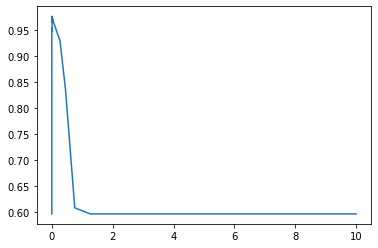

In [27]:
score = []
gamma_range = np.logspace(-10, 1, 50)  # 生成对数空间(默认以10为底)中等间隔的数值序列
for i in gamma_range:
    clf = SVC(kernel="rbf", gamma=i, cache_size=5000).fit(Xtrain, Ytrain)
    score.append(clf.score(Xtest, Ytest))

print(max(score), gamma_range[score.index(max(score))])
plt.plot(gamma_range, score)
plt.show()

通过学习曲线，很容就找出了rbf的最佳gamma值。但我们观察到，这其实与线性核函数的准确率一模一样之前的准确率。我们可以多次调整gamma_range来观察结果，可以发现97.6608应该是rbf核函数的极限了。

但对于多项式核函数来说，一切就没有那么容易了，因为三个参数共同作用在一个数学公式上影响它的效果，因此我们往往使用网格搜索来共同调整三个对多项式核函数有影响的参数。依然使用乳腺癌数据集。

In [42]:
from sklearn.model_selection import GridSearchCV  #网格搜索
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
import datetime

time0 = time()
gamma_range = np.logspace(-10, 1, 20)
coef0_range = np.linspace(0, 5, 10)

param_grid = dict(gamma=gamma_range, coef0=coef0_range)  # 参数字典
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=420)  # 划分5次，每次都使用全部样本
grid = GridSearchCV(SVC(kernel="poly", degree=1, cache_size=5000), param_grid=param_grid, cv=cv)  #创建需要调优的模型对象
grid.fit(X, y)  #训练模型，找到最佳参数

print("The best parameters are %s with a score of %0.5f" % (grid.best_params_, grid.best_score_))
print(datetime.datetime.fromtimestamp(time() - time0).strftime("%M:%S:%f"))  # 分钟：秒：微秒

The best parameters are {'coef0': 0.0, 'gamma': 0.18329807108324375} with a score of 0.96959
00:06:543634


可以发现，网格搜索为我们返回了参数coef0=0，gamma=0.18329807108324375，但整体的分数是0.96959，虽然比调参前略有提高，但依然没有超过线性核函数核和rbf的结果。可见，如果最初选择核函数的时候，你就发现多项式的结果不如rbf和线性核函数，那就不要挣扎了，试试看调整rbf或者直接使用线性。

## 2.3 硬间隔与软间隔：重要参数C

0.9766081871345029 1.2340816326530613


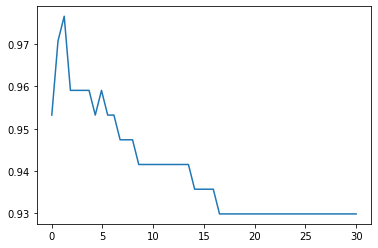

In [43]:
# 调线性核函数
score = []
C_range = np.linspace(0.01, 30, 50)
for i in C_range:
    clf = SVC(kernel="linear", C=i, cache_size=5000).fit(Xtrain, Ytrain)
    score.append(clf.score(Xtest, Ytest))
print(max(score), C_range[score.index(max(score))])
plt.plot(C_range, score)
plt.show()

0.9824561403508771 6.7424489795918365


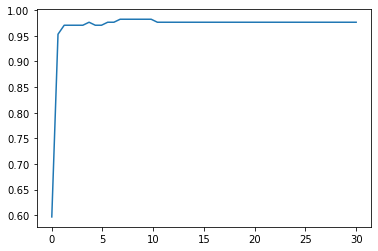

In [44]:
# 调rbf核函数
score = []
C_range = np.linspace(0.01, 30, 50)
for i in C_range:
    clf = SVC(kernel="rbf", C=i, gamma=0.012067926406393264, cache_size=5000).fit(Xtrain, Ytrain)
    score.append(clf.score(Xtest, Ytest))
print(max(score), C_range[score.index(max(score))])
plt.plot(C_range, score)
plt.show()

0.9824561403508771 6.211211211211211


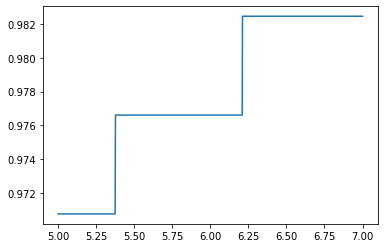

In [48]:
# 进一步细化rbf
score = []
C_range = np.linspace(5, 7, 1000)
for i in C_range:
    clf = SVC(kernel="rbf", C=i, gamma=0.012067926406393264, cache_size=5000).fit(Xtrain, Ytrain)
    score.append(clf.score(Xtest, Ytest))
print(max(score), C_range[score.index(max(score))])
plt.plot(C_range, score)
plt.show()

此时，我们找到了乳腺癌数据集上的最优解：rbf核函数下的98.246%的准确率。当然，我们还可以使用交叉验证来改进我们的模型，获得不同测试集和训练集上的交叉验证结果。但上述过程，为大家展现了如何选择正确的核函数，以及如何调整核函数的参数.